In [1]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from matplotlib import pyplot
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

    
# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
 

# define a configuration for the model
class KangarooConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
 
# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()

# test set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=True)
test_set.prepare()


# define image id
#image_id = 65
# load the image
#image = train_set.load_image(image_id)
# load the masks and the class ids
#mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
#bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
#display_instances(image, bbox, mask, class_ids, train_set.class_names)

# prepare config
config = KangarooConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=3, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Using TensorFlow backend.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20200611T1127\mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3  

C:\Users\Mahesh Kumar M R\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Mahesh Kumar M R\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Mahesh Kumar M R\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/3
131/131 [==============================] - 6023s 46s/step - loss: 0.8937 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1926 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.3492 - val_loss: 0.5391 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.1115 - val_mrcnn_class_loss: 0.0222 - val_mrcnn_bbox_loss: 0.1637 - val_mrcnn_mask_loss: 0.2374
Epoch 2/3
131/131 [==============================] - 8045s 61s/step - loss: 0.5196 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2306 - val_loss: 0.4979 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.1158 - val_mrcnn_class_loss: 0.0249 - val_mrcnn_bbox_loss: 0.1380 - val_mrcnn_mask_loss: 0.2160
Epoch 3/3
131/131 [==============================] - 7041s 54s/step - loss: 0.4397 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.2108 - val_loss: 0.4148 - val_rpn_cl

In [2]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
    # load image info
    info = train_set.image_info[image_id]
    # display on the console
    print(info)

{'id': '00001', 'source': 'dataset', 'path': 'kangaroo/images/00001.jpg', 'annotation': 'kangaroo/annots/00001.xml'}
{'id': '00002', 'source': 'dataset', 'path': 'kangaroo/images/00002.jpg', 'annotation': 'kangaroo/annots/00002.xml'}
{'id': '00003', 'source': 'dataset', 'path': 'kangaroo/images/00003.jpg', 'annotation': 'kangaroo/annots/00003.xml'}
{'id': '00004', 'source': 'dataset', 'path': 'kangaroo/images/00004.jpg', 'annotation': 'kangaroo/annots/00004.xml'}
{'id': '00005', 'source': 'dataset', 'path': 'kangaroo/images/00005.jpg', 'annotation': 'kangaroo/annots/00005.xml'}
{'id': '00006', 'source': 'dataset', 'path': 'kangaroo/images/00006.jpg', 'annotation': 'kangaroo/annots/00006.xml'}
{'id': '00007', 'source': 'dataset', 'path': 'kangaroo/images/00007.jpg', 'annotation': 'kangaroo/annots/00007.xml'}
{'id': '00009', 'source': 'dataset', 'path': 'kangaroo/images/00009.jpg', 'annotation': 'kangaroo/annots/00009.xml'}
{'id': '00010', 'source': 'dataset', 'path': 'kangaroo/images/00

In [3]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [4]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [11]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle

In [6]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_kangaroo_cfg_0003.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)


Instructions for updating:
Use `tf.cast` instead.
Train mAP: 0.893
Test mAP: 0.893


In [7]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [8]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

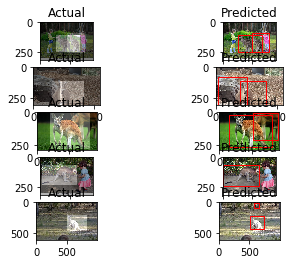

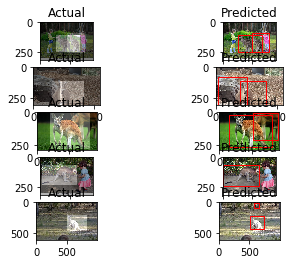

In [12]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_kangaroo_cfg_0003.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)